In [1]:
# importation des librairies

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot


from sklearn import linear_model

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_white , normal_ad


In [3]:
# Définir le répertoire de travail actuel
HOME_DIR = Path.cwd()

# Créer un chemin pour le répertoire 'data' dans le répertoire de travail
DATA_DIR = HOME_DIR / "data"

# Spécifier le chemin complet vers votre fichier 'billets.csv'
file_path = Path("C:/Users/user/Downloads/billets.csv")

# Affichage des chemins
print(f"Répertoire de travail : {HOME_DIR}")
print(f"Répertoire des données : {DATA_DIR}")
print(f"Chemin du fichier : {file_path}")

# you must put the CSV file billets.csv in data directory, cf above cell
data = pd.read_csv(Path(DATA_DIR, "C://Users//user//Downloads//billets.csv"), sep=";")
data.shape  # data frame dimensions (nb rows, nb columns)

Répertoire de travail : C:\Users\user\Downloads
Répertoire des données : C:\Users\user\Downloads\data
Chemin du fichier : C:\Users\user\Downloads\billets.csv


(1500, 7)

In [4]:
data_model = data.loc[lambda dfr: dfr.margin_low.notnull()]

data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


In [5]:
# Création des variables explicatives et cible:
# X est la liste des variables explicatives et y est la variable cible
X = data_model.loc[:, ["diagonal", "height_left", "height_right", "margin_up", "length"]]  # ou data.drop(["margin_low", "is_genuine"], axis=1)
y = data_model.loc[:, 'margin_low']

## Train / Test split

In [7]:
# Séparons nos données en un jeu d'entraînement et un jeu de test :
# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train set - X: {X_train.shape} ; y: {y_train.shape} \nTest set - X: {X_test.shape} ; y: {y_test.shape}")

Train set - X: (1024, 5) ; y: (1024,) 
Test set - X: (439, 5) ; y: (439,)


## Standardisation

In [9]:
# Standardisons les données :

std_scaler = StandardScaler().fit(X_train)  # Standardize features by removing the mean and scaling to unit variance.
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

## Définition d'une fonction d'entrainement

In [11]:
def train_model(model, x_train, y_train, x_test, y_test):
    # On entraîne ce modèle sur les données d'entrainement
    model.fit(x_train, y_train)
    
    # On récupère l'erreur de norme 2 sur le jeu de données train
    error_train = np.mean((model.predict(x_train) - y_train) ** 2)

    # On récupère l'erreur de norme 2 sur le jeu de données test
    error_test = np.mean((model.predict(x_test) - y_test) ** 2)

    # On obtient l'erreur quadratique ci-dessous
    print(f"Model error: {round(error_test, 5)}")
    return {"estimator": model, "error_train": error_train, "error_test": error_test}

## Ridge

In [13]:
# Train and evaluate ridge regression
ridge_error = train_model(model=linear_model.Ridge(alpha=1.),
                          x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test)

Model error: 0.21621


## Lasso

In [15]:

lasso_error = train_model(model=linear_model.Lasso(fit_intercept=True, alpha=1.,),
                          x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test)

Model error: 0.42698


## Elastic-Net

In [17]:
elastic_error = train_model(model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5),
                            x_train=X_train_std, y_train=y_train,
                            x_test=X_test, y_test=y_test)

Model error: 0.42698


C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


<h1 style="color:red">resolution de l'exercice 2</h1>


## Definition d'une fonction qui optimise les modèles

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

# Définir une fonction pour calculer et tracer le MSE en fonction de alpha, et retourner les meilleurs alphas
def plot_mse_vs_alpha(model, X_train, y_train, X_test, y_test, alpha_values):
    mse_values = []  # Liste pour stocker les valeurs de MSE

    # Tester chaque valeur d'alpha
    for alpha in alpha_values:
        model.set_params(alpha=alpha)  # Mettre à jour le paramètre alpha
        model.fit(X_train, y_train)  # Entraîner le modèle
        y_pred = model.predict(X_test)  # Prédictions sur les données de test
        mse = mean_squared_error(y_test, y_pred)  # Calculer le MSE
        mse_values.append(mse)  # Ajouter le MSE à la liste

    # Tracer le graphique MSE vs alpha
    plt.figure(figsize=(8, 6))
    plt.plot(alpha_values, mse_values, marker='o', linestyle='-', color='b')
    plt.xscale('log')  # Utiliser une échelle logarithmique pour alpha
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'MSE en fonction de alpha pour {model.__class__.__name__}')
    plt.grid(True)
    plt.show()

    # Trouver la meilleure valeur de alpha (celle qui minimise le MSE)
    best_alpha = alpha_values[np.argmin(mse_values)]
    best_mse = np.min(mse_values)
    
    print(f"Meilleur alpha : {best_alpha}, MSE : {best_mse}")
    
    return best_alpha, best_mse

### optimisation du modèle ridge

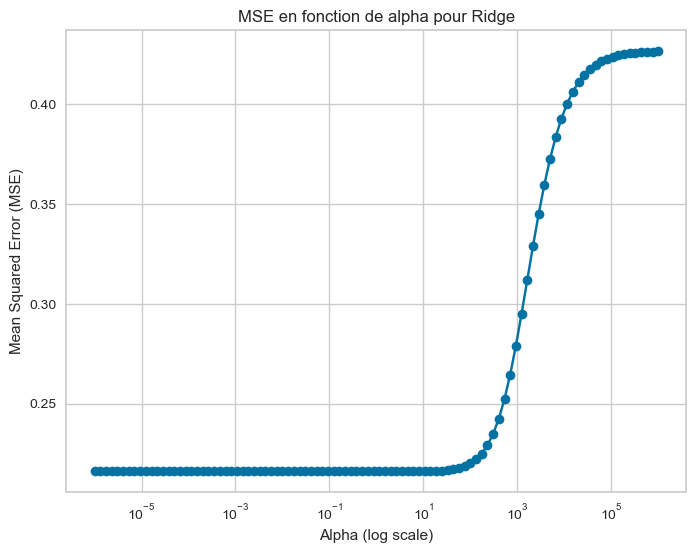

Meilleur alpha : 8.111308307896872, MSE : 0.21612206806019188


In [22]:
# Valeurs possibles pour alpha
alpha_values = np.logspace(-6, 6, 100)  # Plage logarithmique de alpha

# Ridge
ridge_model = Ridge()
best_alpha_ridge, best_mse_ridge = plot_mse_vs_alpha(ridge_model, X_train, y_train, X_test, y_test, alpha_values)


### optimisation du modèle de lasso

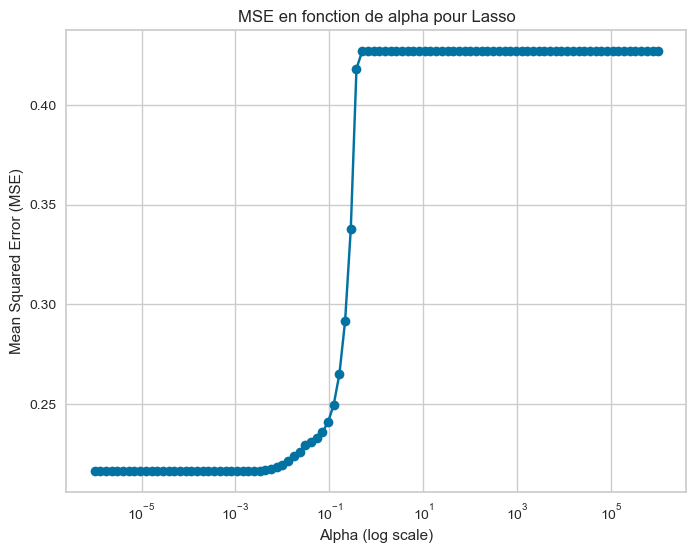

Meilleur alpha : 8.697490026177834e-05, MSE : 0.2162448444156327


In [24]:
# Lasso
lasso_model = Lasso()
best_alpha_lasso, best_mse_lasso = plot_mse_vs_alpha(lasso_model, X_train, y_train, X_test, y_test, alpha_values)

### optimisation du modèle de ElasticNet

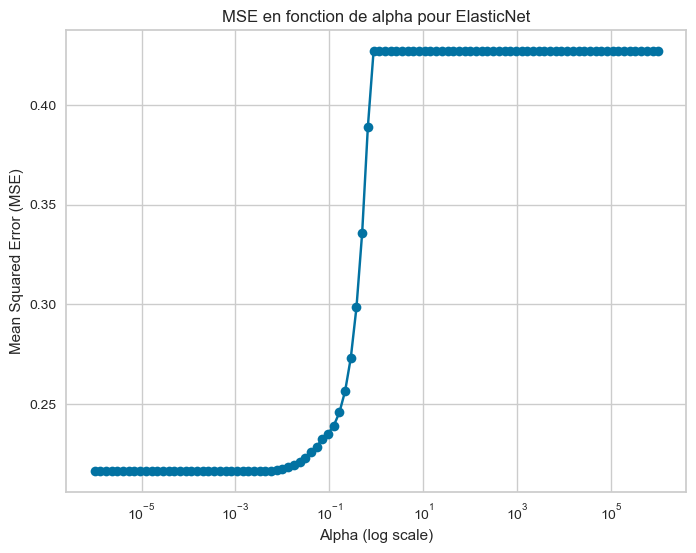

Meilleur alpha : 0.0006135907273413176, MSE : 0.21623808229328378


In [26]:
elasticnet_model = ElasticNet()
best_alpha_elasticnet, best_mse_elasticnet = plot_mse_vs_alpha(elasticnet_model, X_train, y_train, X_test, y_test, alpha_values)

## Etudions l'importance des variables dans chaque modèle

In [28]:
# fonction pour déterminer l'importance des variables 

def feature_importance(model, feature_names):
    importance = model.coef_
    importance_df = pd.DataFrame({
        'Variable': feature_names,
        'Coefficient': importance
    })
    importance_df = importance_df.sort_values(by='Coefficient', ascending=False)
    print(importance_df)


In [29]:
# fonction pour afficher un graphique sur l'importance des variables

def plot_importance(model, feature_names):
    # Extraire les coefficients du modèle
    importance = model.coef_
    
    # Créer un DataFrame avec les variables et leurs coefficients
    importance_df = pd.DataFrame({
        'Variable': feature_names,
        'Coefficient': importance
    })
    
    # Trier les variables par ordre d'importance
    importance_df = importance_df.sort_values(by='Coefficient', ascending=False)
    
    # Visualiser les résultats
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Variable'], importance_df['Coefficient'])
    plt.xlabel('Importance (Coefficient)')
    plt.title('Importance des Variables')
    plt.show()

#### importance des variables dans le modèle de Ridge

Importance des variables pour Ridge:
       Variable  Coefficient
3     margin_up     0.251656
2  height_right     0.247498
1   height_left     0.169197
0      diagonal    -0.081647
4        length    -0.408721


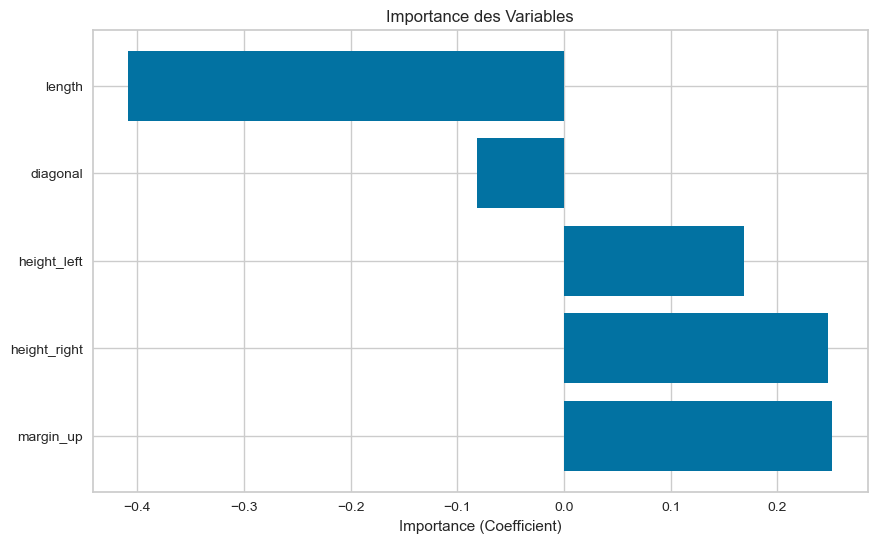

In [31]:

ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)

print("Importance des variables pour Ridge:")
feature_importance(ridge_model, X_train.columns)

plot_importance(ridge_model, X_train.columns)


#### importance des variables dans le modèle de lasso

Importance des variables pour Lasso:
       Variable  Coefficient
3     margin_up     0.286560
2  height_right     0.259765
1   height_left     0.175919
0      diagonal    -0.086914
4        length    -0.405251


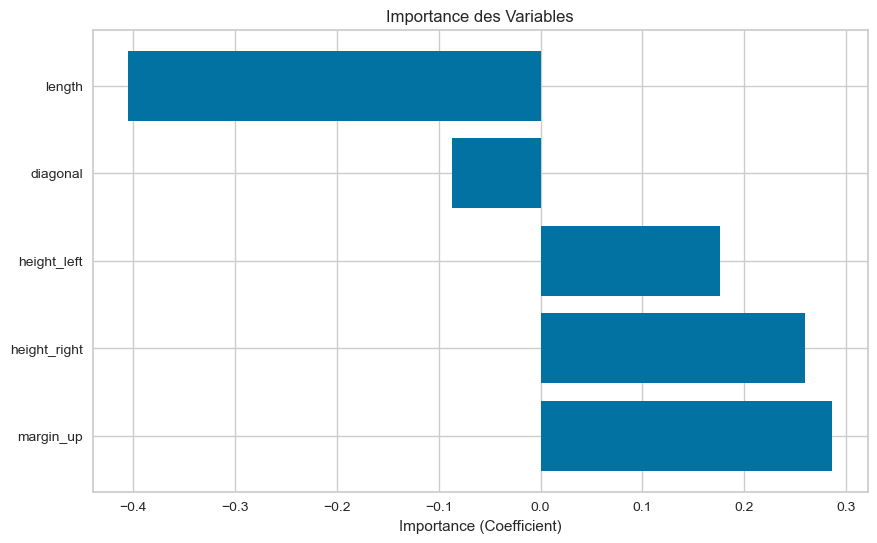

In [33]:
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)

print("Importance des variables pour Lasso:")
feature_importance(lasso_model, X_train.columns)
plot_importance(lasso_model, X_train.columns)

#### importance des variables dans le modèle ElasticNet

Importance des variables pour ElasticNet:
       Variable  Coefficient
3     margin_up     0.280617
2  height_right     0.257720
1   height_left     0.173687
0      diagonal    -0.084253
4        length    -0.406257


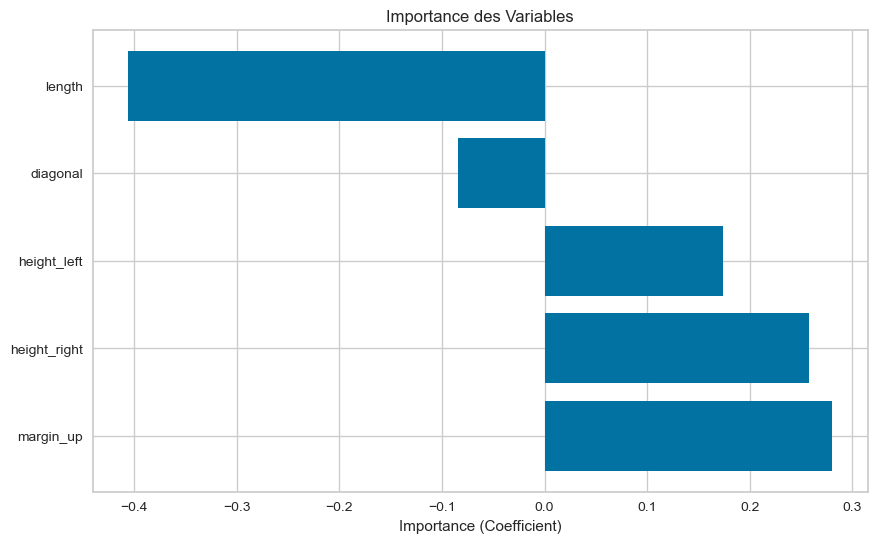

In [35]:
elasticnet_model = ElasticNet(alpha=best_alpha_elasticnet, l1_ratio=0.5)
elasticnet_model.fit(X_train, y_train)

print("Importance des variables pour ElasticNet:")
feature_importance(elasticnet_model, X_train.columns)

plot_importance(elasticnet_model, X_train.columns)

<h1 style="color:red">resolution de l'exercice 1</h1>


### Analyse des variables explicatives

#### Comparaison des distributions des variables explicatives

C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train[column], palette=["blue"])
C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test[column], palette=["orange"])


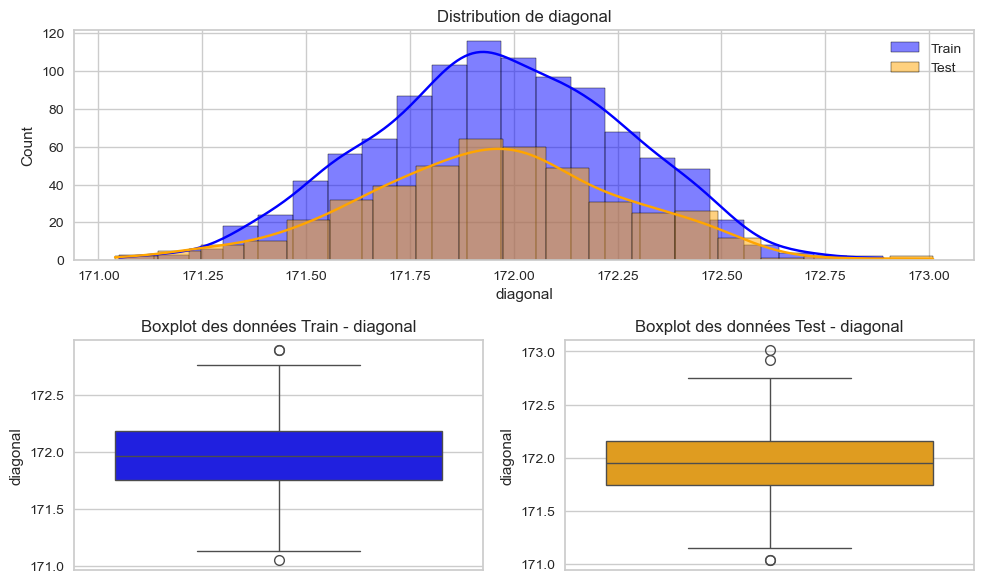

C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train[column], palette=["blue"])
C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test[column], palette=["orange"])


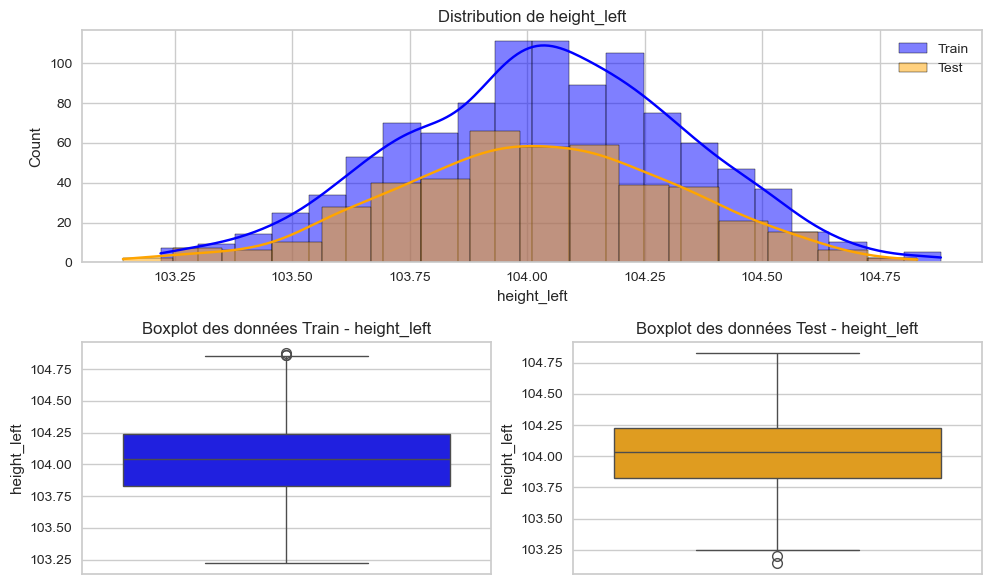

C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train[column], palette=["blue"])
C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test[column], palette=["orange"])


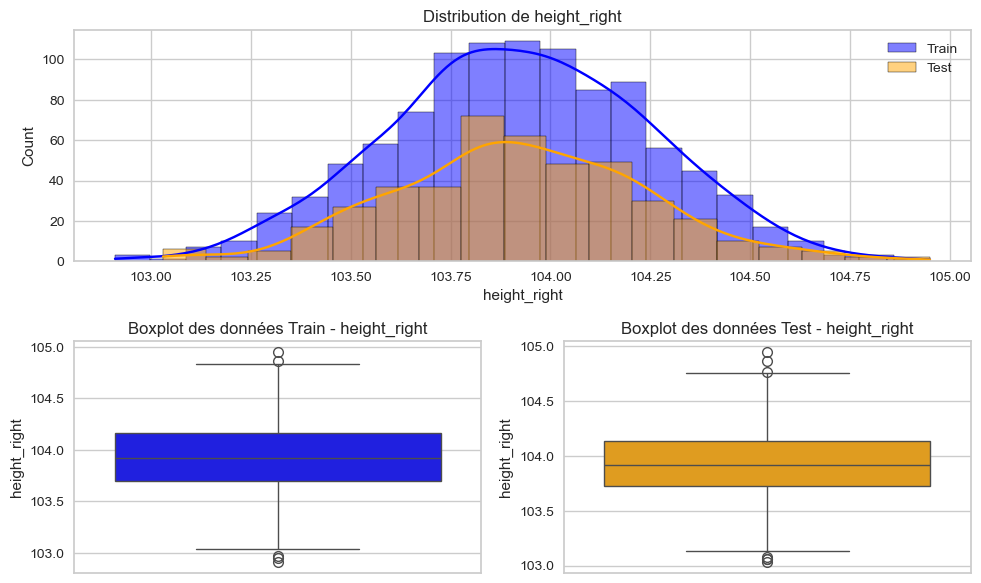

C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train[column], palette=["blue"])
C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test[column], palette=["orange"])


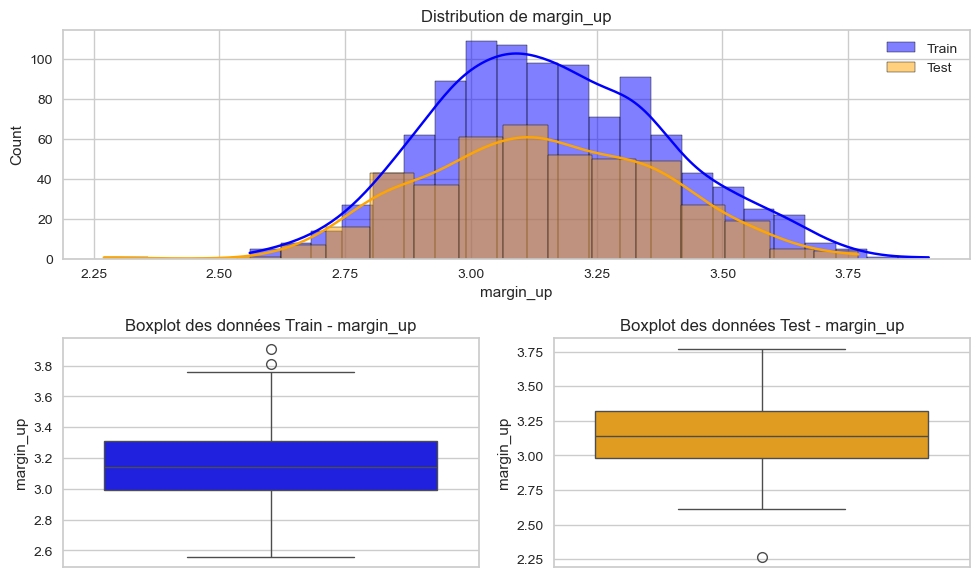

C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train[column], palette=["blue"])
C:\Users\user\AppData\Local\Temp\ipykernel_10032\756102918.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test[column], palette=["orange"])


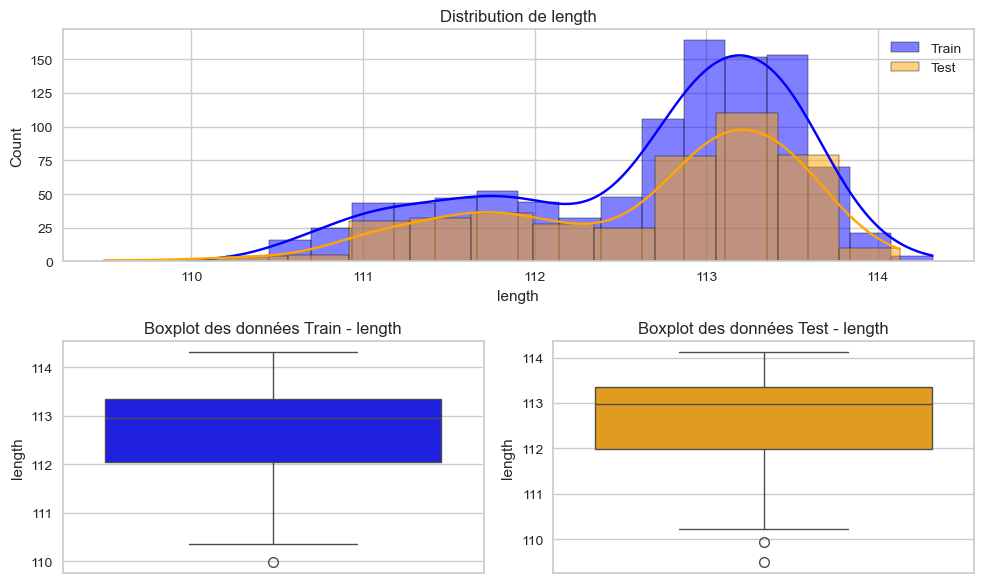

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Parcourir chaque variable dans le jeu d'entraînement et de test
for column in X_train.columns:
    plt.figure(figsize=(10, 6))  # Ajuster la taille de la figure pour plus d'espace

    # Histogramme pour comparer les distributions (en haut)
    plt.subplot(2, 1, 1)  # 2 lignes, 1 colonne, 1ère position pour l'histogramme
    sns.histplot(X_train[column], color='blue', kde=True, label='Train')
    sns.histplot(X_test[column], color='orange', kde=True, label='Test')
    plt.title(f'Distribution de {column}')
    plt.legend()

    # Boxplot pour visualiser la dispersion des données Train (gauche) - sur la 2ème ligne, 1ère colonne
    plt.subplot(2, 2, 3)  # 2 lignes, 2 colonnes, 3ème position pour les boxplots de Train
    sns.boxplot(data=X_train[column], palette=["blue"])
    plt.title(f'Boxplot des données Train - {column}')

    # Boxplot pour visualiser la dispersion des données Test (droite) - sur la 2ème ligne, 2ème colonne
    plt.subplot(2, 2, 4)  # 2 lignes, 2 colonnes, 4ème position pour les boxplots de Test
    sns.boxplot(data=X_test[column], palette=["orange"])
    plt.title(f'Boxplot des données Test - {column}')

    plt.tight_layout()  # Ajuste les sous-graphiques pour éviter le chevauchement
    plt.show()


on voit que Les distributions se ressemblent dans les deux ensembles( entrainement et test) , cela signifie que les deux ensembles sont bien répartis, et que notre modèle devrait être capable de généraliser sans trop de difficulté.

#### Comparez les matrices  de la corrélation entre variables

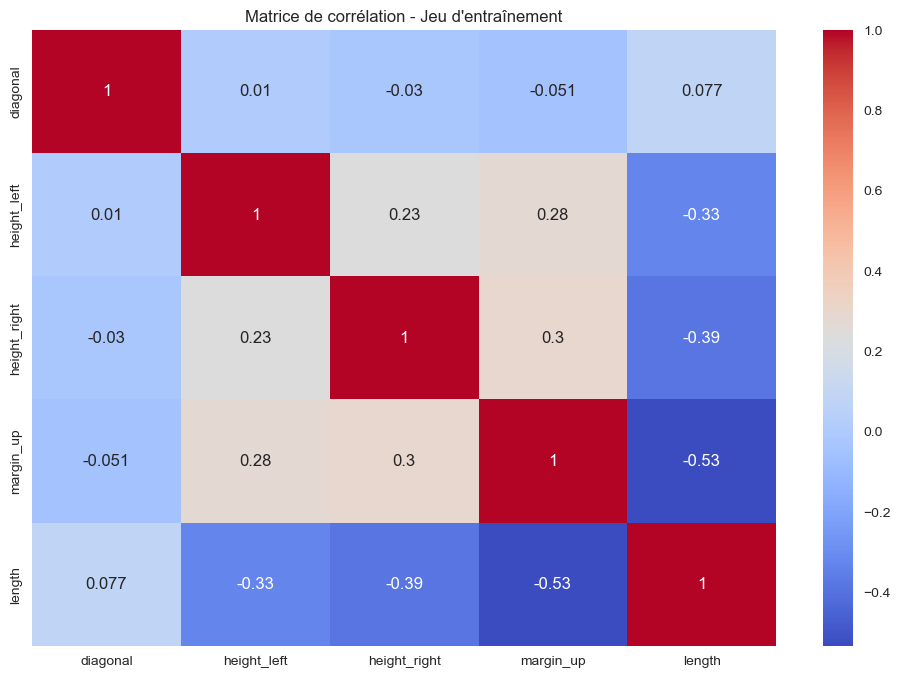

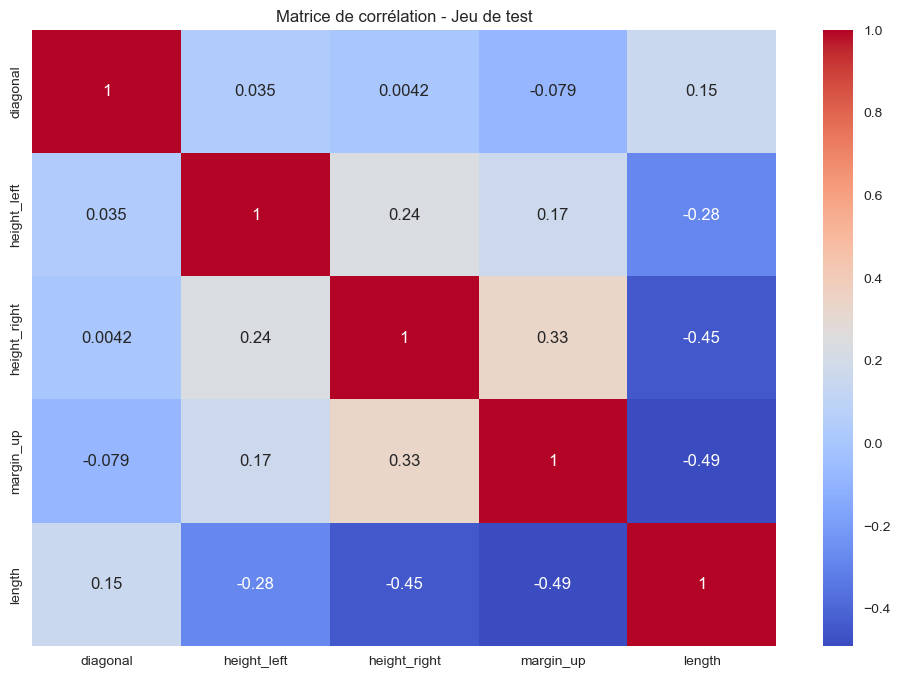

In [42]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation - Jeu d'entraînement")
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(X_test.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation - Jeu de test")
plt.show()

les corrélations entre les variables dans le jeu d'entrainement sont sensiblement les memes que dans le jeu de test

#### Tests de normalité et de variance

##### Test de Kolmogorov-Smirnov

In [46]:
from scipy.stats import ks_2samp, shapiro

# Test de Kolmogorov-Smirnov entre x_train et x_test pour chaque variable
for column in X_train.columns:
    ks_stat, ks_p_value = ks_2samp(X_train[column], X_test[column])
    print(f"Kolmogorov-Smirnov pour {column} : Statistique = {ks_stat:.3f}, p-value = {ks_p_value:.3f}")

# Test de Shapiro-Wilk pour la normalité dans le jeu d'entraînement et de test
for column in X_train.columns:
    shapiro_stat_train, p_value_train = shapiro(X_train[column])
    shapiro_stat_test, p_value_test = shapiro(X_test[column])
    print(f"Shapiro-Wilk pour {column} - Train : Statistique = {shapiro_stat_train:.3f}, p-value = {p_value_train:.3f}")
    print(f"Shapiro-Wilk pour {column} - Test : Statistique = {shapiro_stat_test:.3f}, p-value = {p_value_test:.3f}")


Kolmogorov-Smirnov pour diagonal : Statistique = 0.039, p-value = 0.715
Kolmogorov-Smirnov pour height_left : Statistique = 0.044, p-value = 0.559
Kolmogorov-Smirnov pour height_right : Statistique = 0.037, p-value = 0.780
Kolmogorov-Smirnov pour margin_up : Statistique = 0.040, p-value = 0.689
Kolmogorov-Smirnov pour length : Statistique = 0.036, p-value = 0.814
Shapiro-Wilk pour diagonal - Train : Statistique = 0.998, p-value = 0.238
Shapiro-Wilk pour diagonal - Test : Statistique = 0.997, p-value = 0.697
Shapiro-Wilk pour height_left - Train : Statistique = 0.997, p-value = 0.112
Shapiro-Wilk pour height_left - Test : Statistique = 0.997, p-value = 0.652
Shapiro-Wilk pour height_right - Train : Statistique = 0.999, p-value = 0.929
Shapiro-Wilk pour height_right - Test : Statistique = 0.997, p-value = 0.468
Shapiro-Wilk pour margin_up - Train : Statistique = 0.994, p-value = 0.001
Shapiro-Wilk pour margin_up - Test : Statistique = 0.994, p-value = 0.092
Shapiro-Wilk pour length - Tra

Les p-values du test de Kolmogorov-Smirnov sont toutes élevées (supérieures à 0,05), ce qui signifie que les distributions des variables entre le jeu d’entraînement et le jeu de test ne sont pas significativement différentes. Cela suggère que les deux ensembles ont des distributions similaires pour chaque variable, ce qui est favorable pour la cohérence du modèle.

##### Test de Levene pour l'homogénéité de la variance

In [49]:
from scipy.stats import levene

# Test de Levene pour chaque variable
for column in X_train.columns:
    levene_stat, levene_p_value = levene(X_train[column], X_test[column])
    print(f"Test de Levene pour {column} : Statistique = {levene_stat:.3f}, p-value = {levene_p_value:.3f}")


Test de Levene pour diagonal : Statistique = 0.248, p-value = 0.619
Test de Levene pour height_left : Statistique = 0.000, p-value = 1.000
Test de Levene pour height_right : Statistique = 1.112, p-value = 0.292
Test de Levene pour margin_up : Statistique = 0.101, p-value = 0.751
Test de Levene pour length : Statistique = 0.003, p-value = 0.957


Les p-values du test de Levene pour toutes les variables (diagonal, height_left, height_right, margin_up, length) sont supérieures à 0,05. Cela indique qu’il n’y a pas de différence significative dans les variances entre le jeu d'entraînement et le jeu de test pour ces variables.